In [1]:
# 1d and 2d
import torch as t
from torch import nn
from torch.nn import functional as F


  # 2dCNN
feat_map = 16
drop_out = 0.1

  #feat_map = 16
Conv1d = nn.Sequential(

      nn.Conv1d(in_channels=1, out_channels=feat_map, kernel_size=7, stride=1, padding=1),  # 第一个卷积层
      nn.ReLU(inplace=True),  # 非线性激活层
      nn.Dropout(drop_out),
      nn.MaxPool1d(kernel_size=2),  # 池化大小2*2

      nn.Conv1d(in_channels=feat_map, out_channels=feat_map, kernel_size=7, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Dropout(drop_out),
      nn.MaxPool1d(kernel_size=2),
      nn.Conv1d(in_channels=feat_map, out_channels=feat_map, kernel_size=7, stride=1, padding=1),
      nn.ReLU(inplace=True),
      nn.Dropout(drop_out),
      nn.MaxPool1d(kernel_size=2),
      nn.Conv1d(in_channels=feat_map, out_channels=feat_map, kernel_size=7, stride=1, padding=1),

      nn.Flatten(),
      nn.Linear(192, 50),
      nn.ReLU(inplace=True),
      nn.Linear(50, 2)
      )


In [2]:
def to_batch(x, batch_size):

    num = x.shape[0]
    batch_num = num / batch_size
    batch_num = int(batch_num)

    x = x[:batch_num * batch_size]
    shape = list(x.shape)
    del shape[0]
    shape.insert(0, batch_size)
    shape.insert(0, batch_num)
    y = np.zeros(shape)

    for i in range(batch_num):
        y[i] = x[batch_size * i : batch_size * (i + 1)]
    return y

def to_matrix(x):
  # turn to 2d
    x = np.expand_dims(x, -1)
    one = np.ones([x.shape[0], 1, 160])#1,160 for 1d
    x = one * x
    x = x + np.transpose(x, [0, 2, 1])
    x = np.expand_dims(x, 1)
    return x

def for_cnn(tra_x,tst_x):
    # 使用卷积请运行下方三行代码
    tra_x = to_matrix(tra_x)  # 转化为160*160
    tst_x = to_matrix(tst_x)
    return tra_x,tst_x

In [3]:
## classification 1d/2d

import torch.nn as nn
import numpy as np
#from functions import *

import torch
import time
from torch import nn
#from model import mymodel
import matplotlib.pyplot as plt


data = np.load('./data_40000_08.npz')
Fb = 0.8
x=data['S']
#y = data['RC'];y1 = data['FC'];Y=data['CC'];
F = data['F'];a1 =data['A1'];a2 =data['A2'];
RH = data['RH']

X1 = x
Y1 =RH

occ = int(0.8*len(X1))
batch_size = 200#100#

tra_x = X1[:occ]#X1[:26000]
tra_y = Y1[:occ]

tst_x = X1[occ:]
tst_y = Y1[occ:]


tra_num = tra_x.shape[0]
tst_num = tst_x.shape[0]

occ_posi = round(np.sum(tra_y)/tra_num,3)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
batch_num = tra_num // batch_size
tst_batch_num = tst_num // batch_size

# 使用卷积请运行下方三行代码
#tra_x,tst_x=for_cnn(tra_x,tst_x) # 2d

##1d
tra_x = np.expand_dims(tra_x, -1);#1d
tra_x= np.transpose(tra_x, [0, 2, 1])#为了之后使得tra =【batch，batchsize，1，160】
tst_x = np.expand_dims(tst_x, -1);
tst_x= np.transpose(tst_x, [0, 2, 1])



tra_x = to_batch(tra_x, batch_size)  #
tra_y = to_batch(tra_y, batch_size)
tst_x = to_batch(tst_x, batch_size)
tst_y = to_batch(tst_y, batch_size)


tra_x = torch.tensor(tra_x).to(device).float()
tra_y = torch.tensor(tra_y).to(device).long()
tst_x = torch.tensor(tst_x).to(device).float()
#tst_y = torch.tensor(tst_y).to(device).long()# 设为long就全部失真了



print('size of database:',len(RH), 'batch size',batch_size,'train batch num',batch_num,'test bach num',tst_batch_num)

cpu
size of database: 40000 batch size 200 train batch num 160 test bach num 40


In [4]:

# from model_ResNet34 import ResNet

epochs = 30

learning_rate = 0.0001
net = Conv1d.to(device)  # .cuda()
loss = torch.nn.CrossEntropyLoss().to(device)
opt = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001)
print(net)
tra_loss_list = []
tst_loss_list = []
tra_acc_list = []
tst_acc_list = []
Epoch = []
Tra_loss_batch = np.zeros(shape=(epochs, batch_num))
Tst_loss_batch = np.zeros(shape=(epochs, tst_batch_num))

Tra_acc_batch = np.zeros(shape=(epochs, batch_num))
Tst_acc_batch = np.zeros(shape=(epochs, tst_batch_num))

for epoch in range(epochs):
    Epoch.append(epoch)
    num = 0
    total_loss = 0
    start = time.time()
    for batch in range(batch_num):
        net.train()
        logits = net(tra_x[batch])
        tra_loss = loss(logits, tra_y[batch])

        tra_label = np.argmax(logits.cpu().detach().numpy(), axis=1)
        right_num = np.zeros([batch_size, ])
        right_num[tra_label == tra_y[batch].cpu().detach().numpy()] = 1
        right_num = np.sum(right_num)
        num += right_num

        Tra_acc = right_num / batch_size
        Tra_acc_batch[epoch][batch] = Tra_acc
        Tra_loss = tra_loss.item()
        Tra_loss_batch[epoch][batch] = Tra_loss

        opt.zero_grad()
        tra_loss.backward()
        '''
        for name, param in net.named_parameters():
            #print('层:', name, param.size())
            print('权值梯度', param.grad)
            #print('权值', param)
        '''

        opt.step()
        total_loss += tra_loss.item()
    end = time.time()
    # print('time for one epoach:',end-start,)
    tra_loss_list.append(total_loss / batch_num)
    total_loss / batch_num
    tra_acc = num / tra_num
    tra_acc_list.append(tra_acc)

    net.eval()
    num = 0
    total_loss = 0

    for batch in range(tst_batch_num):
        tst_logits = net(tst_x[batch])
        tst_label = np.argmax(tst_logits.cpu().detach().numpy(), axis=1)
        tst_loss = loss(tst_logits, torch.tensor(tst_y[batch]).to(device).long())

        right_num = np.zeros(tst_y[batch].shape)
        right_num[tst_label == tst_y[batch]] = 1
        right_num = np.sum(right_num)
        num += right_num
        total_loss += tst_loss.item()

        Tst_acc = right_num / batch_size  #
        Tst_acc_batch[epoch][batch] = Tst_acc
        Tst_loss = tst_loss.item()
        Tst_loss_batch[epoch][batch] = Tst_loss

    test_loss = total_loss / tst_batch_num
    tst_loss_list.append(test_loss)
    tst_acc = num / tst_num
    tst_acc_list.append(tst_acc)
    print('Epoch:', epoch, 'train_acc:', tra_acc, 'test_acc:', tst_acc, 'tra_loss:', total_loss / batch_num,
          'test_loss:', test_loss)
    # print('train_acc:', tra_acc, 'test_acc:', tst_acc)







Sequential(
  (0): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=(1,))
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(1,))
  (5): ReLU(inplace=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(1,))
  (9): ReLU(inplace=True)
  (10): Dropout(p=0.1, inplace=False)
  (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv1d(16, 16, kernel_size=(7,), stride=(1,), padding=(1,))
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=192, out_features=50, bias=True)
  (15): ReLU(inplace=True)
  (16): Linear(in_features=50, out_features=2, bias=True)
)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0 train_acc: 0.73759375 test_acc: 0.785 tra_loss: 0.1303242204710841 test_loss: 0.5212968818843364
Epoch: 1 train_acc: 0.785875 test_acc: 0.785 tra_loss: 0.12565116304904222 test_loss: 0.5026046521961689
Epoch: 2 train_acc: 0.83025 test_acc: 0.877125 tra_loss: 0.07728332802653312 test_loss: 0.3091333121061325
Epoch: 3 train_acc: 0.87934375 test_acc: 0.8935 tra_loss: 0.06388532677665353 test_loss: 0.2555413071066141
Epoch: 4 train_acc: 0.89359375 test_acc: 0.905125 tra_loss: 0.05648484565317631 test_loss: 0.22593938261270524
Epoch: 5 train_acc: 0.90340625 test_acc: 0.914125 tra_loss: 0.05145776169374585 test_loss: 0.2058310467749834
Epoch: 6 train_acc: 0.91084375 test_acc: 0.92075 tra_loss: 0.04746796330437064 test_loss: 0.18987185321748257
Epoch: 7 train_acc: 0.91971875 test_acc: 0.928 tra_loss: 0.04442111402750015 test_loss: 0.1776844561100006
Epoch: 8 train_acc: 0.9239375 test_acc: 0.933625 tra_loss: 0.04194084540940821 test_loss: 0.16776338163763285
Epoch: 9 train_acc: 0.9298

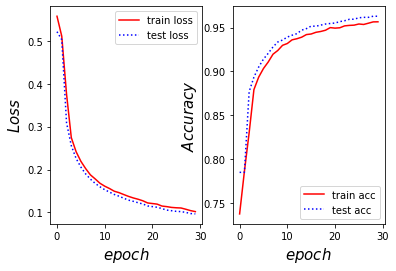

In [5]:
np.savez('class1d.npz',
         Tra_loss_batch=Tra_loss_batch,
         Tst_loss_batch=Tst_loss_batch,
         Tra_acc_batch=Tra_acc_batch,
         Tst_acc_batch=Tst_acc_batch,
         tra_loss_list=tra_loss_list,
         tst_loss_list=tst_loss_list,
         tra_acc_list=tra_acc_list,
         tst_acc_list=tst_acc_list)
torch.save(net.state_dict(),"class1d.pth")

plt.figure()
#plt.style.use('science')
plt.subplot(1,2,1)
plt.plot(Epoch,tra_loss_list, label='train loss', color='red')
plt.plot(Epoch,tst_loss_list, label='test loss', color='blue', linestyle=':')
plt.legend()
plt.xlabel(r'$epoch$',fontsize=15)
plt.ylabel(r'$Loss$',fontsize=15)
plt.subplot(1,2,2)
plt.plot(Epoch,tra_acc_list, label='train acc', color='red')
plt.plot(Epoch,tst_acc_list, label='test acc', color='blue', linestyle=':')
plt.legend()
plt.xlabel(r'$epoch$',fontsize=15)
plt.ylabel(r'$Accuracy$',fontsize=15)
plt.show()